In [53]:
data_path_org = "C:/Thesis/Scripts/vlasov_ngo_data_with_initial.npz"
data_path = "C:/Thesis/Scripts/vlasov_ngo_data_t_10_32_points.npz"

import torch
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch import nn, optim, utils
from torch.utils.data import Dataset, DataLoader, random_split
import opt_einsum


class PDEDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        params = data['params']
        initial_conditions = data['initial_conditions']    
        solutions = data['solutions'] 
        
        self.x = torch.from_numpy(params).float()
        
        # Handle complex-valued solutions
        if np.iscomplexobj(solutions):
            if solutions.ndim == 3:
                solutions = solutions.reshape(solutions.shape[0], -1)
            
            self.y = torch.complex(
                torch.from_numpy(solutions.real).float(),
                torch.from_numpy(solutions.imag).float()
            )
        else: #back-up for some weird case were data would not be complex
            self.y = torch.from_numpy(solutions).float()
            if self.y.ndim == 5:
                self.y = self.y.view(self.y.size(0), -1)

        if np.iscomplexobj(initial_conditions):
            if initial_conditions.ndim == 3:
                initial_conditions = initial_conditions.reshape(initial_conditions.shape[0], -1)

            self.z = torch.complex(
                torch.from_numpy(initial_conditions.real).float(),
                torch.from_numpy(initial_conditions.imag).float()
            )
        
        assert self.x.shape[0] == self.y.shape[0] ==self.z.shape[0], \
            f"Mismatch: inputs {self.x.shape[0]} vs outputs {self.y.shape[0]}"
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.z[idx], self.y[idx]

def integrate(W, values):
    """
    Values shape: (Batch, Time, Velocity) -> (B, 3, 32)
    W shape: (Velocity,) -> (32,)
    Returns: (Batch, Time)
    """
    # Simple trapezoidal-style integration or weighted sum
    # We sum over the last dimension (velocity)
    return torch.sum(values * W, dim=-1)


dataset = np.load(data_path)
full_dataset_test = PDEDataset(data_path)
print(np.shape(dataset['initial_conditions']))
# 1. Check how many samples the Dataset thinks it has
print(f"Dataset length: {len(full_dataset_test)}") 

# 2. Check the shapes of the actual tensors stored inside the class
print(f"Inputs shape: {full_dataset_test.x.shape}")
print(full_dataset_test.z.shape)
print(f"Solutions shape: {full_dataset_test.y.shape}")

# 3. Check the keys inside the .npz file
print(f"Keys in .npz: {dataset.files}")

import torch
import lightning as L

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

(10000, 32)
Dataset length: 10000
Inputs shape: torch.Size([10000, 4])
torch.Size([10000, 32])
Solutions shape: torch.Size([10000, 1024])
Keys in .npz: ['params', 'initial_conditions', 'solutions']
PyTorch version: 2.5.1+cu121
CUDA available: True
GPU Name: Quadro T1000 with Max-Q Design


In [3]:
class GaussLegendreQuadrature:
    """
    Class to compute Gauss-Legendre quadrature points and weights over a domain
    divided into multiple elements.
    """
    def __init__(self, Q, n_elements, dtype, device):
        """
        Initialize the Gauss-Legendre quadrature.

        Args:
            dtype: Data type for the tensors.
            device: Device for the tensors.
            Q (int): Total number of quadrature points.
            n_elements (int): Number of elements to divide the domain into.
        
        Returns:
            None
        """
        self.dtype = dtype
        self.device = device
        self.Q = Q
        self.n_elements = n_elements
        # Compute number of quadrature points per element and element length
        self.Q_per_element = Q//n_elements
        # Length of a single element, assuming domain length is 1
        self.L_element = 1/n_elements
        # Compute quadrature points and weights
        self.w, self.xi = self.compute_quadrature()

    def compute_quadrature(self):
        """
        Compute the Gauss-Legendre quadrature points and weights over the entire domain.

        Args:
            None
            
        Returns:
            torch.Tensor: Weights of shape (Q,).
            torch.Tensor: Quadrature points of shape (Q,).
        """
        # Compute 1D Gauss-Legendre quadrature points and weights for a single element in [-1,1]
        xi, w = np.polynomial.legendre.leggauss(self.Q_per_element)
        # Rescale points and weights to [0, 1]
        xi = 0.5*(xi + 1)
        w = 0.5*w
        # Rescale points and weights to element length
        xi_single = xi*self.L_element
        w_single = w*self.L_element
        # Initialize arrays to hold all quadrature points and weights
        xi = np.empty(0)
        w = np.empty(0)
        # Loop over elements to create full set of quadrature points and weights
        for i in range(0, self.n_elements):
            newpoints = xi_single + self.L_element * i
            xi = np.append(xi, newpoints)
            w = np.append(w, w_single)
        w = torch.tensor(w, dtype=self.dtype, device=self.device)
        xi = torch.tensor(xi, dtype=self.dtype, device=self.device)
        return w, xi
    
    

In [4]:
def torch_repeat(x, repeats, axis=None):
    """
    PyTorch equivalent of np.repeat.

    Parameters
    ----------
    x : torch.Tensor
        Input tensor.
    repeats : int or 1D list/Tensor of ints
        Number of repetitions.
    axis : int or None
        Dimension along which to repeat. If None, the tensor is flattened.

    Returns
    -------
    torch.Tensor
    """

    # Match NumPy: if axis is None, flatten first
    if axis is None:
        x = x.flatten()
        return torch.repeat_interleave(x, repeats)

    # Normalize negative axes
    if axis < 0:
        axis += x.dim()

    # Move target axis to the end
    x = x.transpose(axis, -1)

    # Apply repeat_interleave on last dimension
    out = torch.repeat_interleave(x, repeats, dim=-1)

    # Move axis back
    out = out.transpose(axis, -1)

    return out

In [5]:
class BSplineBasis:
    """
    B-spline basis functions with vectorized evaluation and differentiation using PyTorch.

    Attributes:
        N (int): Number of basis functions.
        p (int): Degree of the B-splines.
        C (int): Continuity at internal knots (C < p).
        t (torch.Tensor): Knot vector.
        L (float): Scaling to parent domain [0,L].
        Dx (float): Translation to parent domain if needed.
        dtype (torch.dtype): Torch data type for computations.
        device (torch.device): Torch device for computations.
    """
    def __init__(self, N, p, C, dtype, device):
        """""
        Initialize the B-spline basis.

        Args:
            N: Number of basis functions.
            p: Degree of the B-splines.
            C: Continuity at internal knots (C < p).
            dtype: Torch data type for computations.
            device: Torch device for computations.
        """
        super().__init__()
        self.dtype = dtype
        self.device = device
        self.N = N
        self.L = 1.0  # Scaling to parent domain [0,L]
        self.Dx = 0 # Translation to parent domain if needed
        self.p = p
        self.C = C
        # Knot vector
         # Repeated knots at start
        self.t = torch.zeros(self.p+1, dtype=self.dtype, device=self.device)
        # Equally spaced internal knots with multiplicity (p - C)
        self.t = torch.cat((
            self.t,
            torch_repeat(
                torch.linspace(
                    0, 1,
                    int((self.N - self.p - 1)/(self.p - self.C)) + 2,
                    dtype=self.dtype, device=self.device
                )[1:-1],
                self.p - self.C
            )
        ))
        # Repeated knots at end
        self.t = torch.cat((self.t, torch.ones(self.p+1, dtype=self.dtype, device=self.device)))
        # Set tolerances based on dtype
        if self.dtype == torch.float32:
            self.rtol, self.atol = 1e-5, 1e-7
        if self.dtype == torch.float64:
            self.rtol, self.atol = 1e-13, 1e-15

    def to(self, dtype, device):
        self.__init__(self.N, self.p, self.C, dtype, device)

    def _basis_dp(self, x: torch.Tensor, p: int) -> torch.Tensor:
        """
        Vectorized Cox–de Boor evaluation for all basis functions in parallel.

        Args:
            x: 1D tensor of evaluation points, shape (Q,).
            return_prev: If True, also returns I_{*,p-1}(x) for derivative.

        Returns:
            I_p: (N, Q) values of I_{i,p}(x).
            I_pm1: (N, Q) values of I_{i,p-1}(x) if return_prev=True, else None.
        """
        # ------------------------------------------------------
        # Degree 0 basis: indicator functions:
        #
        #   I_{i,0}(x) = 1  if  t_i ≤ x < t_{i+1}
        #                0  otherwise
        #
        # This produces an (N,Q) boolean tensor.
        # ------------------------------------------------------
        t_i = self.t[:self.N].unsqueeze(1)       # (N,1)
        t_ip1 = self.t[1:self.N+1].unsqueeze(1)  # (N,1)
        # Use half-open intervals [t_i, t_{i+1})
        I = (t_i <= x) & (x < t_ip1)  # (N,Q) boolean
        # Right-clamping allows the last basis to include x == t_{N+p+1}
        at_right_endpoint = torch.isclose(x, t_ip1[-1], rtol=self.rtol, atol=self.atol)
        # Left-clamping for first basis function
        I[-1] = I[-1] | at_right_endpoint
        
        # If degree is zero, stop here.
        if p == 0:
            return I

        # ------------------------------------------------------
        # Cox–de Boor recurrence:
        #
        #     I_{i,r}(x) = w1 * I_{i,r-1}(x)  +  w2 * I_{i+1,r-1}(x)
        #
        # where
        #
        #     w1 = (x - t_i) / (t_{i+r}   - t_i)
        #     w2 = (t_{i+r+1} - x) / (t_{i+r+1} - t_{i+1})
        #
        # Vectorization strategy:
        #   - I has shape (N,Q) for degree r-1
        #   - I_ip1 is I shifted by one index
        # ------------------------------------------------------
        for r in range(1, p+1):
            # denominators of the weights for degree r
            den1 = (self.t[r:r+self.N] - self.t[:self.N]).unsqueeze(1)          # (N,1)
            den2 = (self.t[r+1:r+1+self.N] - self.t[1:self.N+1]).unsqueeze(1)   # (N,1)

            # Shift basis upward in i-index: I_{i+1, r-1}
            # Last row is zero (no basis above index N-1)
            I_ip1 = torch.cat([I[1:], torch.zeros_like(I[:1])], dim=0)

            # Weights of the Cox-de Boor recursion with safe division
            w1 = torch.where(den1 > 0, (x - self.t[:self.N].unsqueeze(1)) / den1, torch.zeros_like(I))
            w2 = torch.where(den2 > 0, (self.t[r+1:r+1+self.N].unsqueeze(1) - x) / den2, torch.zeros_like(I))

            # Apply Cox–de Boor recurrence
            I = w1 * I + w2 * I_ip1

        # return basis of degree p
        return I

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Evaluate all B-spline basis functions I_{i,p}(x) in parallel.

        Args:
            x: 1D tensor of points, shape (Q,).

        Returns:
            (B=1, N, Q) tensor with I_{i,p}(x).
        """
        # Scale x to parent domain
        x = (x - self.Dx) / self.L
        # Compute basis functions
        output = self._basis_dp(x, self.p)
        # Add batch dimension
        output = output[None,:,:]
        return output
    
    def derivative(self, x: torch.Tensor, n: int) -> torch.Tensor:
        """
        Evaluate n-th derivatives d^n/dx^n I_{i,p}(x) for all i in parallel.

        Args:
            x: 1D tensor of points, shape (Q,).
            n: Order of the derivative.

        Returns:
            (B, N, Q) tensor with d^n/dx^n I_{i,p}(x).
        
        Notes:
            Uses the known B-spline derivative formula:
            d/dx I_{i,p}(x)
            = p/(t_{i+p} - t_i) * I_{i,p-1}(x)
            - p/(t_{i+p+1} - t_{i+1}) * I_{i+1,p-1}(x)
        """
        # Scale x to parent domain
        x = (x - self.Dx) / self.L

        # Select starting basis functions I_{*, p-n}
        dI = self._basis_dp(x, self.p - n)
        # Set polynomial degree for first iteration (order of starting basis functions + 1)
        p_temp = self.p - n + 1
        # Iteratively apply derivative formula n times on starting basis functions
        for k in range(n):
            # Compute weights
            den1 = (self.t[p_temp:p_temp+self.N] - self.t[:self.N]).unsqueeze(1)
            den2 = (self.t[p_temp+1:p_temp+1+self.N] - self.t[1:self.N+1]).unsqueeze(1)
            w1 = torch.where(den1 > 0, p_temp / den1, torch.zeros_like(dI))
            w2 = torch.where(den2 > 0, p_temp / den2, torch.zeros_like(dI))
            # Shift basis upward in i-index: I_{i+1, p_temp-1}
            dI_ip1 = torch.cat([dI[1:], torch.zeros_like(dI[:1])], dim=0)
            # Update derivative
            dI = w1 * dI - w2 * dI_ip1
            # Increase temporary polynomial degree
            p_temp += 1
        # Final derivative
        output = dI
        # Add batch dimension
        output = output[None,:,:]
        # Scale derivative back to original domain
        output = output / (self.L ** n)
        return output
    
    def grad(self, x: torch.Tensor) -> torch.Tensor:
        """
        Evaluate derivatives d/dx I_{i,p}(x) for all i in parallel.

        Args:
            x: 1D tensor of points, shape (Q,).

        Returns:
            (B, N, Q) tensor with d/dx I_{i,p}(x).
        """
        return self.derivative(x, n=1)  

    def laplacian(self, x: torch.Tensor) -> torch.Tensor:
        """
        Evaluate second derivatives d^2/dx^2 I_{i,p}(x) for all i in parallel.

        Args:
            x: 1D tensor of points, shape (Q,).

        Returns:
            (B, N, Q) tensor with d^2/dx^2 I_{i,p}(x).
        """
        return self.derivative(x, n=2)
    
from numpy.linalg import svd, lstsq

# def prony_growth_rate(t, signal, n_modes=5):
#     """
#     Extract dominant exponential growth rates from a signal
#     using the Matrix Pencil method (robust Prony variant).
#     """
#     N = len(signal)
#     L = N // 3  # pencil parameter
    
#     # Build Hankel matrix
#     H0 = np.array([[signal[i+j]   for j in range(L)] for i in range(N-L)])
#     H1 = np.array([[signal[i+j+1] for j in range(L)] for i in range(N-L)])
    
#     # SVD truncation to n_modes
#     U, s, Vh = svd(H0)
#     U_r, s_r, Vh_r = U[:,:n_modes], np.diag(s[:n_modes]), Vh[:n_modes,:]
    
#     # Generalized eigenvalue problem → poles
#     Z = np.linalg.pinv(U_r) @ H1 @ Vh_r.conj().T @ np.linalg.pinv(s_r)
#     poles = np.linalg.eigvals(Z)
    
#     dt = t[1] - t[0]
#     lambdas = np.log(poles) / dt
#     return lambdas

def prony_growth_rate(t, signal, n_modes=5):
    N = len(signal)
    L = max(n_modes + 1, N // 2)  # L must be > n_modes, use N//2 for best conditioning
    L = min(L, N - 1)             # but can't exceed N-1
    
    H0 = np.array([[signal[i+j]   for j in range(L)] for i in range(N-L)])
    H1 = np.array([[signal[i+j+1] for j in range(L)] for i in range(N-L)])
    
    # Clamp n_modes to what SVD can actually give us
    n_modes = min(n_modes, min(H0.shape))
    
    U, s, Vh = np.linalg.svd(H0)
    U_r  = U[:, :n_modes]            # (N-L, n_modes)
    s_r  = np.diag(s[:n_modes])      # (n_modes, n_modes)
    Vh_r = Vh[:n_modes, :]           # (n_modes, L)

    # Z is (n_modes, n_modes) — square by construction
    Z = np.linalg.pinv(U_r) @ H1 @ Vh_r.conj().T @ np.linalg.pinv(s_r)
    
    poles = np.linalg.eigvals(Z)     # now guaranteed square
    dt = t[1] - t[0]
    lambdas = np.log(poles + 1e-12) / dt
    return lambdas

In [6]:
# # Parameters matching your data
# Nt, Nv = 32, 32
# t_grid = torch.linspace(0.0, 10.0, Nt, dtype=torch.float32, device='cpu')  # Your time grid
# v_grid = torch.linspace(-4.0, 4.0, Nv, dtype=torch.float32, device='cpu')  # Your velocity grid

# # Create B-spline bases
# N_basis_t = 12   # Number of time basis functions (choose based on smoothness needs)
# N_basis_v = 12  # Number of velocity basis functions
# K = N_basis_t * N_basis_v  # Total number of 2D basis functions

# basis_t = BSplineBasis(N=N_basis_t, p=3, C=2, dtype=torch.float32, device='cpu')
# basis_v = BSplineBasis(N=N_basis_v, p=3, C=2, dtype=torch.float32, device='cpu')

# # Evaluate the bases on your grids
# # Normalize t_grid and v_grid to [0, 1] for the B-spline class
# t_norm = (t_grid - t_grid.min()) / (t_grid.max() - t_grid.min())
# v_norm = (v_grid - v_grid.min()) / (v_grid.max() - v_grid.min())

# B_t = basis_t.forward(t_norm)  # Shape: (1, N_basis_t, Nt)
# B_v = basis_v.forward(v_norm)  # Shape: (1, N_basis_v, Nv)

# # Remove batch dimension
# B_t = B_t.squeeze(0)  # (N_basis_t, Nt)
# B_v = B_v.squeeze(0)  # (N_basis_v, Nv)

# # Create 2D tensor product basis via outer product
# # Result shape: (N_basis_t, N_basis_v, Nt, Nv)
# basis_2d = torch.einsum('ti,vj->tivj', B_t, B_v)

# # Flatten to (K, Nt*Nv) for the network
# basis_matrix = basis_2d.reshape(K, Nt * Nv)  # (72, 256)

def relative_l2_loss(y_pred, y_true):
# y shape: (batch, time, velocity)
# Calculate error and norm over the velocity/time dimensions
    diff_norm = torch.norm(y_pred - y_true, p=2, dim=(1, 2))
    true_norm = torch.norm(y_true, p=2, dim=(1, 2))
    return torch.mean(diff_norm / (true_norm + 1e-8))

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as L


class VlasovModele(L.LightningModule):
    def __init__(self, 
                 input_dim=4, 
                 Nv=32, 
                 Nt=32, 
                 basis_v=None,      # (K, Nv)
                 basis_tv=None):    # (K, Nt*Nv)

        super().__init__()

        if basis_v is None or basis_tv is None:
            raise ValueError("Must provide basis_v and basis_tv")

        self.Nv = Nv
        self.Nt = Nt
        self.K = basis_v.shape[0]

        # Register basis as buffers (not trainable)
        self.register_buffer("basis_v", basis_v.float())     # (K, Nv)
        self.register_buffer("basis_tv", basis_tv.float())   # (K, Nt*Nv)

        # Precompute quadrature weights (trapezoidal rule)
        vmin, vmax = -4.0, 4.0
        dv = (vmax - vmin) / (Nv - 1)

        weights = torch.ones(Nv)
        weights[0] *= 0.5
        weights[-1] *= 0.5
        weights *= dv

        self.register_buffer("quad_weights", weights)  # (Nv,)

        # -------------------------------
        # Branch network: learns A_mn(theta)
        # Output size = K*K complex = 2*K*K reals
        # -------------------------------

        self.branch = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * self.K * self.K)
        )

        self.loss_fn = nn.MSELoss()

    # ==========================================================
    # FORWARD
    # ==========================================================
    def forward(self, params, initial_conditions):
        """
        params: (B, input_dim)
        initial_conditions: (B, Nv) complex
        """

        B = params.shape[0]

        # ------------------------------------------------------
        # 1) Project initial condition onto velocity basis
        # d_n = ∫ ψ_n(v) f0(v) dv
        # ------------------------------------------------------

        f0 = initial_conditions  # (B, Nv) complex

        # Apply quadrature weights
        weighted_f0 = f0 * self.quad_weights.unsqueeze(0)  # (B, Nv)

        # Projection: (B, Nv) @ (Nv, K) -> (B, K)
        # Using real basis
        d_n_real = torch.einsum(
            "bn,kn->bk",
            weighted_f0.real,
            self.basis_v
        )

        d_n_imag = torch.einsum(
            "bn,kn->bk",
            weighted_f0.imag,
            self.basis_v
        )

        d_n = torch.complex(d_n_real, d_n_imag)  # (B, K)

        # ------------------------------------------------------
        # 2) Learn operator matrix A_mn(theta)
        # ------------------------------------------------------

        A_out = self.branch(params)  # (B, 2*K*K)

        A_real = A_out[:, :self.K*self.K].view(B, self.K, self.K)
        A_imag = A_out[:, self.K*self.K:].view(B, self.K, self.K)

        A = torch.complex(A_real, A_imag)  # (B, K, K)

        # ------------------------------------------------------
        # 3) Apply operator to modal coefficients
        # d̃_m = A_mn d_n
        # ------------------------------------------------------

        d_tilde = torch.einsum("bmn,bn->bm", A, d_n)  # (B, K)

        # ------------------------------------------------------
        # 4) Reconstruct solution in space-time
        # f = ψ_m(v,t) d̃_m
        # ------------------------------------------------------

        f_real = torch.einsum(
            "bm,mx->bx",
            d_tilde.real,
            self.basis_tv
        )

        f_imag = torch.einsum(
            "bm,mx->bx",
            d_tilde.imag,
            self.basis_tv
        )

        f = torch.complex(f_real, f_imag)  # (B, Nt*Nv)

        return f

    # ==========================================================
    # TRAINING
    # ==========================================================
    def training_step(self, batch, batch_idx):
        params, initial_conditions, solution = batch

        preds = self(params, initial_conditions)

        y_hat = preds.view(-1, self.Nt, self.Nv)
        y_true = solution.view(-1, self.Nt, self.Nv)

        loss = relative_l2_loss(y_hat, y_true)

        self.log("train_loss", loss)
        return loss

    # ==========================================================
    # VALIDATION
    # ==========================================================
    def validation_step(self, batch, batch_idx):
        params, initial_conditions, solution = batch

        preds = self(params, initial_conditions)

        y_hat = preds.view(-1, self.Nt, self.Nv)
        y_true = solution.view(-1, self.Nt, self.Nv)

        val_loss = relative_l2_loss(y_hat, y_true)

        self.log("val_loss", val_loss, prog_bar=True)
        return val_loss

    # ==========================================================
    # OPTIMIZER
    # ==========================================================
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

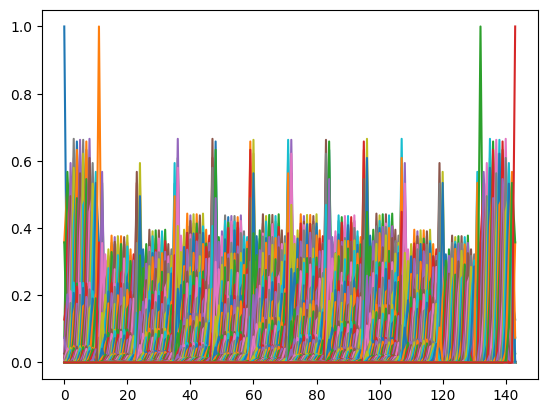

In [60]:
import torch

# Grid sizes
Nt, Nv = 32, 32
N_basis_t, N_basis_v = 12, 12

# Create grids
t_grid = torch.linspace(0.0, 10.0, Nt)
v_grid = torch.linspace(-4.0, 4.0, Nv)

# Normalize to [0,1]
t_norm = (t_grid - t_grid.min()) / (t_grid.max() - t_grid.min())
v_norm = (v_grid - v_grid.min()) / (v_grid.max() - v_grid.min())

# Create 1D spline bases
basis_t = BSplineBasis(N_basis_t, p=3, C=2, dtype=torch.float32, device="cpu")
basis_v = BSplineBasis(N_basis_v, p=3, C=2, dtype=torch.float32, device="cpu")

# Evaluate 1D bases
B_t = basis_t.forward(t_norm).squeeze(0)  # (N_basis_t, Nt)
B_v = basis_v.forward(v_norm).squeeze(0)  # (N_basis_v, Nv)

# ---- Tensor product construction ----

# Outer product construction
basis_2d = B_t[:, :, None, None] * B_v[None, None, :, :]

# Reorder to (N_basis_t, N_basis_v, Nt, Nv)
basis_2d = basis_2d.permute(0, 2, 1, 3)

# Flatten to matrix form
basis_matrix = basis_2d.reshape(
    N_basis_t * N_basis_v,
    Nt * Nv
)

# Slice at the first index of the Nt dimension (index 2)
# Resulting shape: (N_basis_t, N_basis_v, Nv)
basis_at_t0 = basis_2d[:, :, 0, :]

# Flatten to match your matrix form (N_basis_t * N_basis_v, Nv)
basis_at_t0_flat = basis_at_t0.reshape(N_basis_t * N_basis_v, Nv)




# print("B_t shape:", B_t.shape)
# print("B_v shape:", B_v.shape)
# print("2D basis shape:", basis_2d.shape)
# print("Flattened matrix shape:", basis_matrix.shape)


import torch

def generate_spline_basis(Nt=32, Nv=32, N_basis_t=12, N_basis_v=12, device="cpu"):
    """
    Generates the 2D tensor-product spline basis matrix and its slice at t=0.
    """
    # 1. Create and Normalize Grids
    t_grid = torch.linspace(0.0, 10.0, Nt, device=device)
    v_grid = torch.linspace(-4.0, 4.0, Nv, device=device)

    t_norm = (t_grid - t_grid.min()) / (t_grid.max() - t_grid.min())
    v_norm = (v_grid - v_grid.min()) / (v_grid.max() - v_grid.min())

    # 2. Evaluate 1D Spline Bases
    # Assuming BSplineBasis class is defined in your environment
    basis_t_evaluator = BSplineBasis(N_basis_t, p=3, C=2, dtype=torch.float32, device=device)
    basis_v_evaluator = BSplineBasis(N_basis_v, p=3, C=2, dtype=torch.float32, device=device)

    B_t = basis_t_evaluator.forward(t_norm).squeeze(0)  # (N_basis_t, Nt)
    B_v = basis_v_evaluator.forward(v_norm).squeeze(0)  # (N_basis_v, Nv)

    # 3. Construct 2D Tensor Product: (N_basis_t, Nt, N_basis_v, Nv)
    basis_2d = B_t[:, :, None, None] * B_v[None, None, :, :]

    # 4. Reorder to (N_basis_t, N_basis_v, Nt, Nv)
    basis_2d = basis_2d.permute(0, 2, 1, 3)

    # 5. Generate Full Basis Matrix: (K, Nt * Nv) where K = N_basis_t * N_basis_v
    K = N_basis_t * N_basis_v
    basis_matrix = basis_2d.reshape(K, Nt * Nv)

    # 6. Generate Slice at t=0: (K, Nv)
    # Slicing the Nt dimension at index 0
    basis_t0 = basis_2d[:, :, 0, :].reshape(K, Nv)

    return basis_matrix, basis_t0

b_full, b_t0 = generate_spline_basis(32,32,12,12)

plt.plot(b_full)
plt.show()

In [71]:
class VlasovModel(L.LightningModule):
    def __init__(self, input_dim=4, Nv=32, Nt=32, basis_matrix=None,basis_term=None):
        super().__init__()
        self.output_dim = Nt * Nv  # 256
        self.Nt = Nt
        self.Nv = Nv
        
        
        
        # Basis setup
        if basis_matrix is None:
            raise ValueError("Must provide precomputed basis_matrix")
        self.K = basis_matrix.shape[0]  # Number of basis functions
        
        # Register basis as a fixed buffer (not trained)
        # For complex solutions, we use the SAME real basis for both real/imag parts
        self.register_buffer('basis_matrix', basis_matrix)  # (K, 256)
        self.register_buffer('basis_imag', torch.zeros_like(basis_matrix))  # No imaginary basis
        self.register_buffer('basis_term', basis_term)
        
        # Branch network: outputs K complex coefficients (2K reals)
        # initial_size = Nv * 2  # Initial condition flattened (real + imag)
        total_input = input_dim
        
        self.branch = nn.Sequential(
            nn.Linear(total_input, 512),
            nn.ReLU(),
            nn.Linear(512, 1028),
            nn.ReLU(),
            nn.Linear(1028,1028),
            nn.ReLU(),
            nn.Linear(1028, self.K * self.K * 2)  # K complex = 2K reals
        )
        
        # self.loss_fn = nn.MSELoss()

    def forward(self, params, initial_conditions):
        batch_size = params.shape[0]
        # 1. Compute the Projection Term: integral(basis_at_t0 * f0) dv
        # basis_at_t0_flat shape: (K, Nv)
        # initial_conditions shape: (Batch, Nv)
        dv = (4 - (-4)) / (self.Nv - 1)
        
        # Complex projection of IC onto each basis function at t=0
        # (Batch, Nv) @ (Nv, K) -> (Batch, K)
        d_term = torch.matmul(initial_conditions, self.basis_term.to(torch.complex64).T) * dv

        # 2. Branch network outputs A(params)
        # Note: params is now the ONLY input to the network
        out = self.branch(params)  # Expected output shape: (Batch, 2*K)
        
        A_real = out[..., :self.K**2].view(batch_size, self.K, self.K)
        A_imag = out[..., self.K**2:].view(batch_size, self.K, self.K)
        A_matrix = torch.complex(A_real, A_imag) # (Batch, K)

        # 3. Apply the formula: A[params] * projection
        # Element-wise multiplication of the learned coefficients and the IC projection
        combined_coeffs = torch.matmul(A_matrix, d_term.unsqueeze(-1)).squeeze(-1)  # (Batch, K)

        # 4. Final Reconstruction using the 2D basis
        # basis_2d_flat shape: (K, Nt * Nv)
        # (Batch, K) @ (K, Nt * Nv) -> (Batch, Nt * Nv)
        pred_flat = torch.matmul(combined_coeffs, self.basis_matrix.to(torch.complex64))
        
        # Reshape to (Batch, Nt, Nv)
        return pred_flat.view(batch_size, self.Nt, self.Nv)

    
    def training_step(self, batch, batch_idx):
        params, initial_conditions, solution = batch
        preds = self(params, initial_conditions)

        y_hat = preds.view(-1, 32, 32)
        y_true = solution.view(-1, 32, 32)

        W = torch.ones(32, device=self.device)
        diff_sq = (y_hat.real - y_true.real)**2 + (y_hat.imag - y_true.imag)**2
        true_sq = y_true.real**2 + y_true.imag**2

        l2_diff = integrate(W, diff_sq)**(0.5)
        l2_norm = integrate(W, true_sq)**(0.5)
        
        #loss_back_up = torch.mean(l2_diff / torch.clamp(l2_norm, min=1e-7))

        loss = relative_l2_loss(y_hat,y_true)

        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        params, initial_conditions, solution = batch
        preds = self(params, initial_conditions)
        y_hat_val = preds.view(-1, 32, 32)
        y_true_val = solution.view(-1, 32, 32)
        #val_loss_org = self.loss_fn(preds.real, solution.real) + self.loss_fn(preds.imag, solution.imag)
        val_loss = relative_l2_loss(y_hat_val,y_true_val)
        self.log("val_loss", val_loss, prog_bar=True)
        return val_loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)
    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode  | FLOPs
------------------------------------------------------
0 | branch | Sequential | 44.3 M | train | 0    
------------------------------------------------------
44.3 M    Trainable params
0         Non-trainable params
44.3 M    Total params
177.050   Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\20213341\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\20213341\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


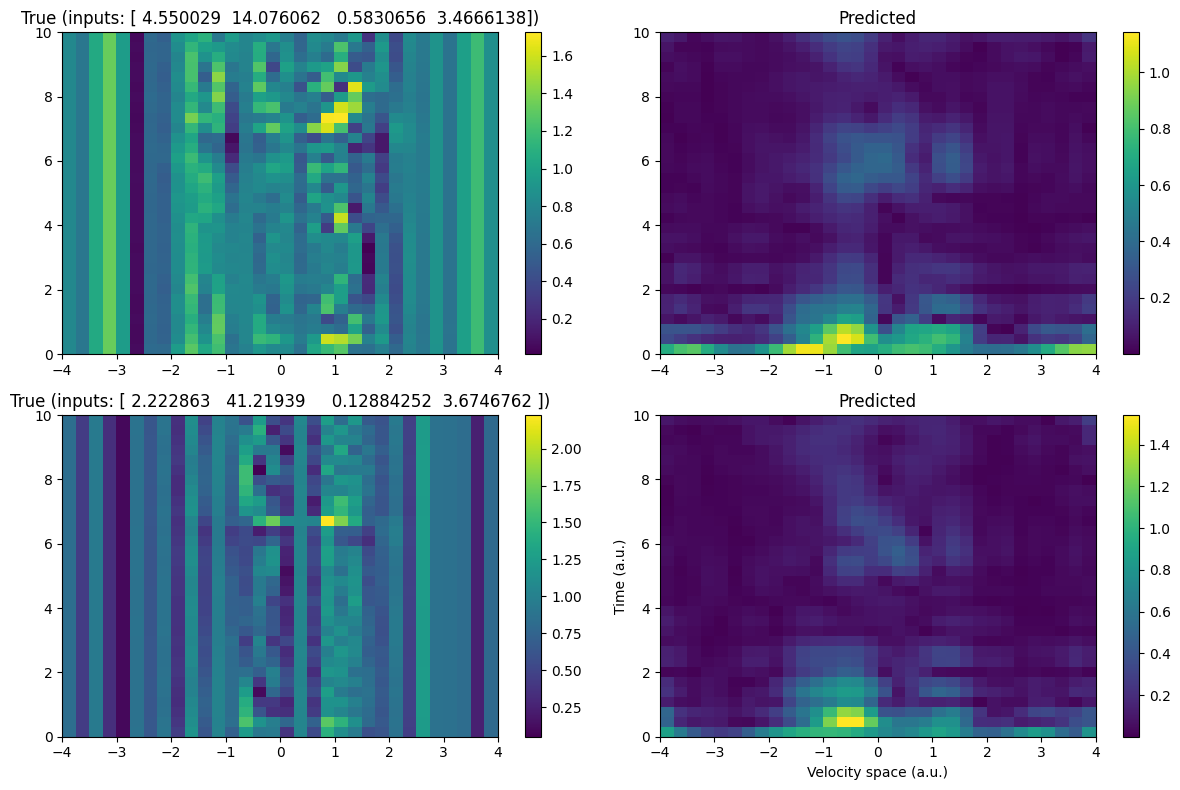

In [72]:
# --- 3. Execution Block ---
if __name__ == "__main__":
    # 1. Load and Split Data

    basis_matrix, basis_t0 = generate_spline_basis(
        Nt=32, Nv=32, 
        N_basis_t=12, N_basis_v=12, 
        device="cpu"
    )

    full_dataset = PDEDataset(data_path)
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_set, val_set = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32)
    
    # 2. Initialize Model
    model = VlasovModel(input_dim=4, Nv=32, Nt=32, basis_matrix=basis_matrix,basis_term=basis_t0)  # Changed from 1 to 96
    
    # 3. Train
    trainer = L.Trainer(max_epochs=50, accelerator="auto")
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    
# --- Compare several validation samples ---
model.eval()

num_samples = 2
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))

for i in range(num_samples):
    params, initial_cond, solution = val_set[i]

    # Predict
    with torch.no_grad():
        y_pred = model(params.unsqueeze(0), initial_cond.unsqueeze(0)).squeeze(0)

    # Plot
    true_grid = solution.view(32, 32).abs().numpy()
    pred_grid = y_pred.view(32, 32).abs().numpy()

    t_min, t_max = 0.0, 10.0
    v_min, v_max = -4, 4 
    plot_extent = [v_min, v_max, t_min, t_max]

    im1 = axes[i, 0].imshow(true_grid, aspect='auto',extent = plot_extent, origin = 'lower')
    axes[i, 0].set_title(f"True (inputs: {params.numpy()})")
    plt.colorbar(im1, ax=axes[i, 0])
    plt.xlabel("Velocity space (a.u.)")
    plt.ylabel("Time (a.u.)")
    
    im2 = axes[i, 1].imshow(pred_grid, aspect='auto',extent = plot_extent, origin = 'lower')
    axes[i, 1].set_title(f"Predicted")
    plt.colorbar(im2, ax=axes[i, 1])
    plt.xlabel("Velocity space (a.u.)")
    plt.ylabel("Time (a.u.)")

plt.tight_layout()
plt.show()

TypeError: Image data of dtype complex64 cannot be converted to float

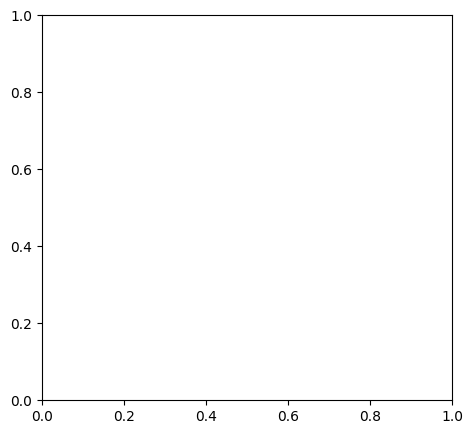

In [37]:
# --- Adapted Plotting Code ---

# 1. Get a sample for visualization
model.eval()
with torch.no_grad():
    # Assuming 'val_loader' or 'test_loader' is available
    batch = next(iter(val_loader))
    params, initial_cond, targets = batch
    preds = model(params, initial_cond)

# Select one sample from the batch to plot (e.g., index 0)
idx = 0
target_sample = targets[idx].cpu().numpy()
pred_sample = preds[idx].cpu().numpy()

# 2. Calculate global min/max for normalization
# We exclude the 'Difference' plot from this scale as it's usually much smaller
vmin = min(target_sample.min(), pred_sample.min())
vmax = max(target_sample.max(), pred_sample.max())

plt.figure(figsize=(18, 5))

# --- Ground Truth ---
plt.subplot(1, 3, 1)
im1 = plt.imshow(target_sample.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title("Ground Truth")
plt.xlabel("Time/Iteration")
plt.ylabel("Velocity Grid")
plt.colorbar(im1)

# --- Prediction ---
plt.subplot(1, 3, 2)
# Using the same vmin and vmax ensures the colors represent the same values
im2 = plt.imshow(pred_sample.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title("DeepONet Prediction")
plt.xlabel("Time/Iteration")
plt.ylabel("Velocity Grid")
plt.colorbar(im2)

# --- Absolute Error ---
plt.subplot(1, 3, 3)
diff = np.abs(target_sample - pred_sample)
im3 = plt.imshow(diff.T, aspect='auto', origin='lower', cmap='inferno')
plt.title("Absolute Difference")
plt.xlabel("Time/Iteration")
plt.ylabel("Velocity Grid")
plt.colorbar(im3)

plt.tight_layout()
plt.show()

Closest sample index: 632
Closest params: tensor([ 5.4299, 50.3854,  0.4246,  2.2258])


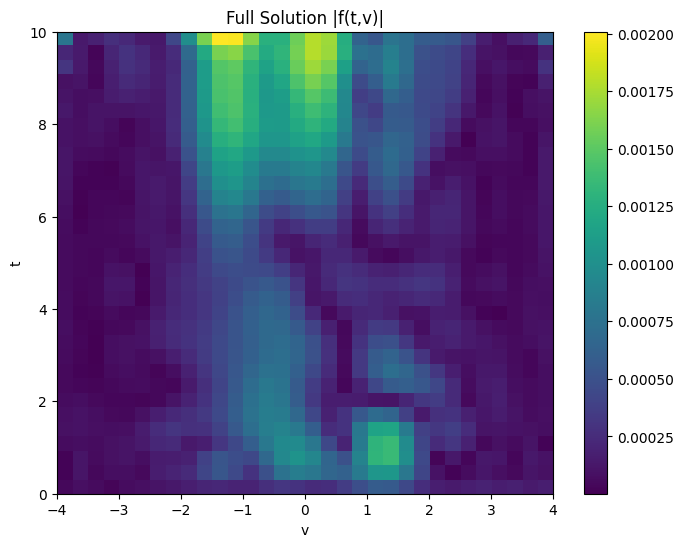

Estimated Dominant Growth Rate (gamma): 0.0827


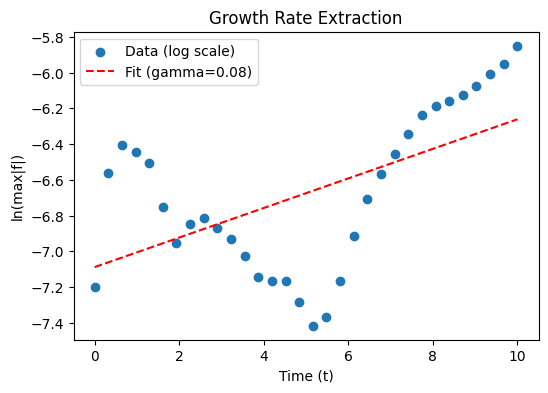

[-0.40190065+3.7335567j -0.40190065-3.7335567j -5.6824374 +9.738938j
  0.26709026+0.j        -0.02611751+1.3449253j -0.02611751-1.3449253j
 -0.7616859 +0.j        -4.6129136 +0.j       ]


In [73]:
model.eval()

# Create input parameters as tensor with batch dimension
params_custom = torch.tensor([[6, 50.0, 0.7, 2.0]], dtype=torch.float32)  # Shape: (1, 4)

Nt = 32
Nv = 32
v = np.linspace(-4,4,Nv)
# Create zero forcing with batch dimension
initial_perurbation = 0.001 * np.exp(-v**2 / 2) / np.sqrt(2 * np.pi)  # Shape: (1, 16, 32)
initial_condition = torch.from_numpy(initial_perurbation).to(torch.complex64)

params, initial_cond, solution_from_data = val_set[80]








import torch
import numpy as np

# Find closest match in dataset to params_custom
params_custom_tensor = torch.tensor([[6, 50.0, 0.7, 2.0]], dtype=torch.float32)

# Collect all params from the dataset
all_params = []
for i in range(len(val_set)):
    p, _, _ = val_set[i]
    all_params.append(p)

all_params_tensor = torch.stack(all_params)  # Shape: (N, 4)

# Normalize differences (optional but useful if params have different scales)
diffs = all_params_tensor - params_custom_tensor  # broadcasting
distances = torch.norm(diffs, dim=1)              # L2 distance

closest_idx = torch.argmin(distances).item()
print(f"Closest sample index: {closest_idx}")

# Retrieve the solution from data
params_closest, initial_cond_closest, solution_closest = val_set[closest_idx]
print(f"Closest params: {params_closest}")
with torch.no_grad():
    solution_prediction = model(params_custom, initial_condition)  # Shape: (1, 512)

# Now you can set grid to this solution
grid = solution_prediction.view(32, 32).abs().numpy()











#Plot the solution
# grid_2 = solution_prediction[0].view(32, 32).abs().cpu().numpy()  # [0] removes batch dim
# grid = solution_prediction.view(32, 32).abs().numpy() # this line can be changed into solution_prediction too

t_min, t_max = 0.0, 10.0
v_min, v_max = -4, 4 
plot_extent = [v_min, v_max, t_min, t_max]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(grid, aspect='auto', cmap='viridis',extent=plot_extent,origin='lower')
ax.set_title("Full Solution |f(t,v)|")
ax.set_xlabel("v")
ax.set_ylabel("t")
plt.colorbar(im, ax=ax)
plt.show()

import numpy as np
dv = v[1] - v[0]

# 1. Define the time vector
times = np.linspace(t_min, t_max, Nt)  # [0.0, 0.15, 0.3]

# 2. Calculate the "Amplitude" at each time step
# We use the maximum value of |f| across velocity space for each time
amplitudes_2 =  np.max(grid,axis=1)
# Calculate L2 norm across the velocity space (axis 1)
amplitudes = np.sqrt(np.sum(np.abs(grid)**2, axis=1) * dv)

# 3. Perform a linear fit to the logarithm of the amplitudes
# ln(A) = slope * t + intercept -> slope is our gamma
log_amps = np.log(amplitudes + 1e-12) # Added epsilon to avoid log(0)
slope, intercept = np.polyfit(times, log_amps, 1)

print(f"Estimated Dominant Growth Rate (gamma): {slope:.4f}")

# Optional: Visualize the fit
plt.figure(figsize=(6, 4))
plt.scatter(times, log_amps, label='Data (log scale)')
plt.plot(times, slope*times + intercept, color='red', linestyle='--', label=f'Fit (gamma={slope:.2f})')
plt.xlabel("Time (t)")
plt.ylabel("ln(max|f|)")
plt.legend()
plt.title("Growth Rate Extraction")
plt.show()


# Usage: only needs a SHORT time window
t_short = np.linspace(0, 8, 8)  # Much shorter than your current approach
# time_evol = np.exp(np.outer(t_short, evals))
# sol_short = np.einsum('tj,j,vj->tv', time_evol, coeffs, evecs)


amps_short = np.sqrt(np.sum(np.abs(grid)**2, axis=1) * dv)

lambdas = prony_growth_rate(times, amps_short, n_modes=8)
gamma_prony = np.max(lambdas.real)
print(lambdas)

In [ ]:
import numpy as np
from scipy.linalg import eig

# 1. Setup specific test parameters (matching your params_custom)
omega_n, omega_Ti, ky, kz = 2.0, 20.0, 0.4, 3.0
t_test = np.linspace(0.0, 0.3, 3) # Nt=3 as in your prediction
v_test = np.linspace(-4, 4, 32)
dv = v_test[1] - v_test[0]

# 2. Reconstruct Operator A
v_matrix = np.diag(v_test)
F0 = (1.0 / np.pi**0.5) * np.exp(-v_test**2)
Integral_Operator = np.diag(F0) @ (np.ones((32, 32)) * dv)
bracket_term = omega_n + (v_test**2 - 0.5) * omega_Ti
A = -1j*kz*v_matrix - 1j*kz*(v_matrix @ Integral_Operator) - 1j*ky*(np.diag(bracket_term) @ Integral_Operator)

# 3. Solve Eigenproblem
evals, evecs = eig(A)

# 4. Use the same coefficients logic as your training data
# Note: If you want to match a specific initial condition, 
# you'd solve: coeffs = np.linalg.solve(evecs, initial_condition)
np.random.seed(42) # For reproducibility
c_i = np.random.uniform(0.01, 1.0, size=32) + 1j * np.random.uniform(0.01, 1.0, size=32)
initial_perturbation = 0.001 * np.exp(-v**2 / 2) / np.sqrt(2 * np.pi)


# 5. Generate "Ground Truth" Solution
time_evol = np.exp(np.outer(t_test, evals))
true_solution = np.einsum('tj, j, vj -> tv', time_evol, initial_perturbation, evecs)

# 6. Extraction Check
true_grid = np.abs(true_solution)
amps = np.sqrt(np.sum(np.square(grid), axis=1)) #np.max(true_grid, axis=1)
log_amps = np.log(amps + 1e-12)
slope, _ = np.polyfit(t_test, log_amps, 1)

# 7. Compare with Physics
actual_max_gamma = np.max(evals.real)

print(f"--- Verification ---")
print(f"Theoretical Max Gamma (from Eigenvalues): {actual_max_gamma:.4f}")
print(f"Extracted Gamma (from 3-point fit):      {slope:.4f}")
print(f"Difference: {abs(actual_max_gamma - slope):.4f}")

TypeError: expected x and y to have same length

--- Verification at t=20.0 ---
Theoretical Max Gamma (Eigenvalue): 0.0000
Extracted Gamma (Slope of L2 Norm): -0.0034
Error:                              0.0034


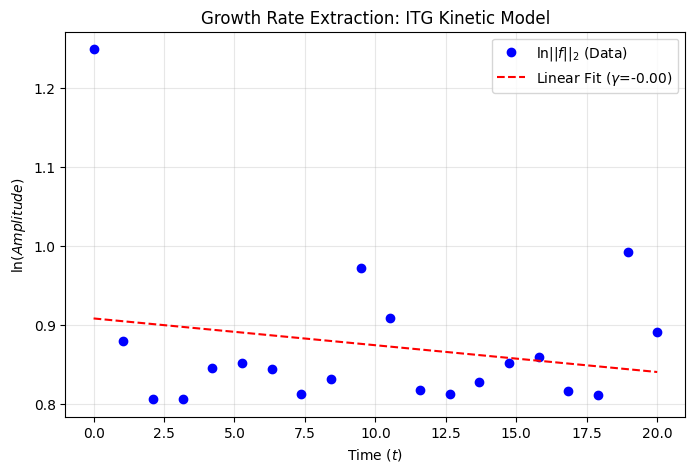

In [8]:
import numpy as np
from scipy.linalg import eig, solve
import matplotlib.pyplot as plt

# --- 1. Parameters ---
omega_n, omega_Ti, ky, kz = 19, 10, 0.55, 2.5
t_max = 20.0 
Nt = 20        # Increased for a smoother fit
t_test = np.linspace(0.0, t_max, Nt)
v_test = np.linspace(-4, 4, 32)
dv = v_test[1] - v_test[0]

# --- 2. Reconstruct Operator A ---
v_matrix = np.diag(v_test)
F0 = (1.0 / np.sqrt(np.pi)) * np.exp(-v_test**2)

# Integral operator: effectively calculates \int f dv and multiplies by F0(v)
Integral_Operator = np.outer(F0, np.ones(len(v_test))) * dv
bracket_term = omega_n + (v_test**2 - 0.5) * omega_Ti
A = -1j*kz*v_matrix - 1j*kz*(v_matrix @ Integral_Operator) - 1j*ky*(np.diag(bracket_term) @ Integral_Operator)

# --- 3. Solve Eigenproblem ---
evals, evecs = eig(A)

# --- 4. Projection of Initial Condition ---
# f(0, v) = Sum(c_i * evec_i)
initial_perturbation = 0.001 * np.exp(-v_test**2 / 2) / np.sqrt(2 * np.pi)
coeffs = solve(evecs, initial_perturbation) 

ranges = {
    'omega_n':  [0.0, 20.0],
    'omega_Ti': [10.0, 60.0],
    'ky':       [0.1, 1.0],
    'kz':       [1.0, 4.0],
    'c_i':      [0.01, 1.0]
}

coeffs = np.random.uniform(*ranges['c_i'], size=Nv) + \
        1j * np.random.uniform(*ranges['c_i'], size=Nv)

# --- 5. Generate Ground Truth Solution ---
# Shape of time_evol: (Nt, N_eigenvalues)
time_evol = np.exp(np.outer(t_test, evals))
# true_solution: (time, velocity)
true_solution = np.einsum('tj, j, vj -> tv', time_evol, coeffs, evecs)

# --- 6. Extraction Check (L2 Norm) ---
# Calculate the L2 norm for each time step: ||f(t)||_2 = sqrt( sum(|f|^2) * dv )
# We use axis=1 to sum over the velocity dimension
amps = np.sqrt(np.sum(np.abs(true_solution)**2, axis=1) * dv)
log_amps = np.log(amps + 1e-12)

# Linear fit to extract gamma (slope of log growth)
slope, intercept = np.polyfit(t_test, log_amps, 1)
actual_max_gamma = np.max(evals.real)

# --- 7. Output Results ---
print(f"--- Verification at t={t_max} ---")
print(f"Theoretical Max Gamma (Eigenvalue): {actual_max_gamma:.4f}")
print(f"Extracted Gamma (Slope of L2 Norm): {slope:.4f}")
print(f"Error:                              {abs(actual_max_gamma - slope):.4f}")

# Visualizing the log-growth
plt.figure(figsize=(8, 5))
plt.plot(t_test, log_amps, 'ob', label=r'$\ln ||f||_2$ (Data)')
plt.plot(t_test, slope*t_test + intercept, 'r--', label=f'Linear Fit ($\gamma$={slope:.2f})')
plt.title(f"Growth Rate Extraction: ITG Kinetic Model")
plt.xlabel("Time ($t$)")
plt.ylabel(r"$\ln(Amplitude)$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Targeting < 1.0% error. Theory Gamma: 0.1884

Time       | Extracted       | Rel. Error (%) 
---------------------------------------------
2.00       | 0.0514          | 72.71          %
---------------------------------------------
SUCCESS: Convergence reached at t = 101.80


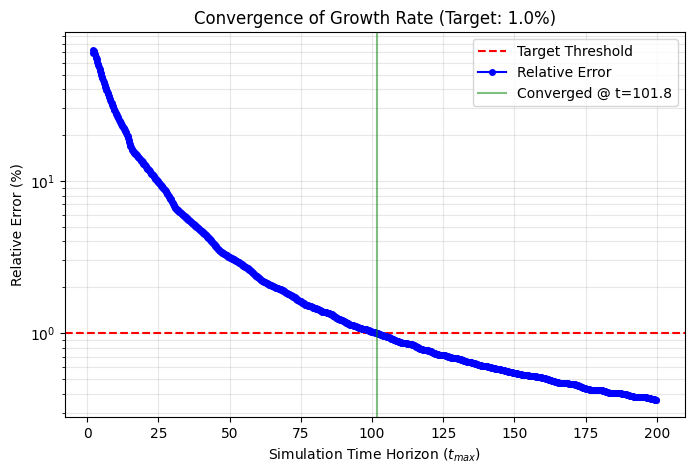

[[ 1.33830226e-07-1.63270890e-27j  2.20620945e-07+3.24121340e-26j
   3.57879058e-07-1.23263572e-25j ...  3.57879058e-07-3.23042966e-26j
   2.20620945e-07-8.93452118e-27j  1.33830226e-07+1.28857943e-26j]
 [ 6.34053103e-08+1.17316460e-07j  1.11391525e-07+1.89062904e-07j
   1.91786675e-07+2.98785726e-07j ...  1.86381058e-07-3.08172016e-07j
   1.09135018e-07-1.92830853e-07j  6.24963732e-08-1.18776981e-07j]
 [-7.34440516e-08+1.10532023e-07j -1.07433860e-07+1.89408956e-07j
  -1.50771020e-07+3.16782192e-07j ... -1.66428400e-07-3.24915575e-07j
  -1.13837890e-07-1.92447657e-07j -7.59693997e-08-1.11620335e-07j]
 ...
 [-6.35375932e-08-1.19002572e-07j  1.32914185e-07+1.67716594e-07j
  -2.74731936e-07-2.40909333e-07j ... -2.71328067e-07+2.49290813e-07j
   1.42166357e-07-1.72718049e-07j -6.23587689e-08+1.20689048e-07j]
 [ 7.34051814e-08-1.12008549e-07j -8.25487828e-08+1.99463116e-07j
   4.84258387e-08-3.59601434e-07j ...  6.23199488e-08+3.72517657e-07j
  -8.01190986e-08-2.05419128e-07j  7.63158015e-

In [13]:
import numpy as np
from scipy.linalg import eig, solve
import matplotlib.pyplot as plt

# --- 1. User Configuration ---
TARGET_ERROR_PCT = 1.0  # The percentage error threshold (e.g., 1%)
MAX_SEARCH_TIME = 200.0  # Upper bound for the search
T_STEP = 0.2            # Increments to check

# Physics Parameters
omega_n, omega_Ti, ky, kz =  11.8877, 45.2720, 0.2026, 2.6729 # 3, 56, 0.7, 2.5
v_test = np.linspace(-4, 4, 64) # Higher resolution for better accuracy
dv = v_test[1] - v_test[0]

# --- 2. Setup Operator and Theoretical Gamma ---
v_matrix = np.diag(v_test)
F0 = (1.0 / np.sqrt(np.pi)) * np.exp(-v_test**2)
Integral_Operator = np.outer(F0, np.ones(len(v_test))) * dv
bracket_term = omega_n + (v_test**2 - 0.5) * omega_Ti
A = -1j*kz*v_matrix - 1j*kz*(v_matrix @ Integral_Operator) - 1j*ky*(np.diag(bracket_term) @ Integral_Operator)

evals, evecs = eig(A)
gamma_theory = np.max(evals.real)
initial_perturbation = 0.001 * np.exp(-v_test**2 / 2) / np.sqrt(2 * np.pi)
coeffs = solve(evecs, initial_perturbation)

# --- 3. Convergence Loop ---
convergence_data = []
found_time = None

print(f"Targeting < {TARGET_ERROR_PCT}% error. Theory Gamma: {gamma_theory:.4f}\n")
print(f"{'Time':<10} | {'Extracted':<15} | {'Rel. Error (%)':<15}")
print("-" * 45)

for t_limit in np.arange(2.0, MAX_SEARCH_TIME, T_STEP):
    # Generate solution for this specific time window
    t_axis = np.linspace(0, t_limit, 20)
    time_evol = np.exp(np.outer(t_axis, evals))
    sol = np.einsum('tj, j, vj -> tv', time_evol, coeffs, evecs)
    
    # Extract growth rate
    amps = np.sqrt(np.sum(np.abs(sol)**2, axis=1) * dv)
    slope, _ = np.polyfit(t_axis, np.log(amps + 1e-12), 1)
    # Extract growth rate
    # amps = np.sqrt(np.sum(np.abs(sol)**2, axis=1) * dv)

    # # Instantaneous growth rate between consecutive timesteps (like the Fortran code)
    # dt = t_axis[1] - t_axis[0]
    # inst_gammas = np.log(amps[1:] / amps[:-1]) / dt

    # # Take the mean over the second half, where dominant mode has taken over
    # slope = np.mean(inst_gammas[len(inst_gammas)//2:])
    rel_error = abs((slope - gamma_theory) / gamma_theory) * 100
    convergence_data.append((t_limit, rel_error))
    
    if t_limit % 2 == 0: # Print every 2 units of time
        print(f"{t_limit:<10.2f} | {slope:<15.4f} | {rel_error:<15.2f}%")

    if rel_error <= TARGET_ERROR_PCT and found_time is None:
        found_time = t_limit

# --- 4. Results & Visualization ---
if found_time:
    print("-" * 45)
    print(f"SUCCESS: Convergence reached at t = {found_time:.2f}")
else:
    print("FAILED: Did not reach target error within MAX_SEARCH_TIME.")

times, errors = zip(*convergence_data)
plt.figure(figsize=(8, 5))
plt.axhline(y=TARGET_ERROR_PCT, color='r', linestyle='--', label='Target Threshold')
plt.plot(times, errors, 'b-o', markersize=4, label='Relative Error')
if found_time:
    plt.axvline(x=found_time, color='g', alpha=0.5, label=f'Converged @ t={found_time:.1f}')

plt.yscale('log')
plt.title(f"Convergence of Growth Rate (Target: {TARGET_ERROR_PCT}%)")
plt.xlabel("Simulation Time Horizon ($t_{max}$)")
plt.ylabel("Relative Error (%)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

from numpy.linalg import svd, lstsq

def prony_growth_rate(t, signal, n_modes=5):
    """
    Extract dominant exponential growth rates from a signal
    using the Matrix Pencil method (robust Prony variant).
    """
    N = len(signal)
    L = N // 3  # pencil parameter
    
    # Build Hankel matrix
    H0 = np.array([[signal[i+j]   for j in range(L)] for i in range(N-L)])
    H1 = np.array([[signal[i+j+1] for j in range(L)] for i in range(N-L)])
    
    # SVD truncation to n_modes
    U, s, Vh = svd(H0)
    U_r, s_r, Vh_r = U[:,:n_modes], np.diag(s[:n_modes]), Vh[:n_modes,:]
    
    # Generalized eigenvalue problem → poles
    Z = np.linalg.pinv(U_r) @ H1 @ Vh_r.conj().T @ np.linalg.pinv(s_r)
    poles = np.linalg.eigvals(Z)
    
    dt = t[1] - t[0]
    lambdas = np.log(poles) / dt
    return lambdas

# Usage: only needs a SHORT time window
t_short = np.linspace(0, 10, 100)  # Much shorter than your current approach
time_evol = np.exp(np.outer(t_short, evals))
sol_short = np.einsum('tj,j,vj->tv', time_evol, coeffs, evecs)
amps_short = np.sqrt(np.sum(np.abs(sol_short)**2, axis=1) * dv)
print(sol_short)


lambdas = prony_growth_rate(t_short, amps_short, n_modes=32)
gamma_prony = np.max(lambdas.real)
print(f"Prony extracted: {gamma_prony:.4f} vs theory: {gamma_theory:.4f}")

In [ ]:
def extract_dominant_mode(model, input_params):
    """
    Extract the dominant eigenmode from model prediction.
    
    Args:
        model: Trained neural network
        input_params: Array or tensor of 4 input values
    
    Returns:
        eigenvalue: Complex number (growth rate + i*frequency)
        eigenvector: Complex array of shape (32,) - the spatial pattern
    """
    model.eval()
    
    # 1. Get prediction from model
    if not torch.is_tensor(input_params):
        input_params = torch.tensor(input_params, dtype=torch.float32)
    if input_params.dim() == 1:
        input_params = input_params.unsqueeze(0)
    
    with torch.no_grad():
        solution = model(input_params)  # Shape: (1, 96) complex
    
    # 2. Reshape to (3 time, 32 space)
    solution = solution.squeeze(0).view(5, 32).cpu().numpy()
    
    # 3. SVD to find dominant spatial pattern
    U, S, Vh = np.linalg.svd(solution, full_matrices=False)
    # Vh[0] is the dominant eigenvector (spatial pattern)
    eigenvector = Vh[0]  # Shape: (32,)
    
    # 4. Estimate eigenvalue from time evolution
    # The dominant mode evolves as: amplitude * exp(λ * t)
    t = np.array([0.0, 0.125, 0.25, 0.375, 0.5])  # YOUR ACTUAL TIME VALUES HERE
    mode_amplitude = U[:, 0] * S[0]  # How this mode evolves in time
    
    # Estimate λ from two consecutive time points
    eigenvalue = np.log(mode_amplitude[1] / mode_amplitude[0]) / (t[1] - t[0])
    
    return eigenvalue, eigenvector


# Usage:
if __name__ == "__main__":
    # ... after training ...
    
    # Test with specific input parameters
    test_params = [5.0, 40.0, 0.3, 3.0]  # Your 4 input values
    
    eigenvalue, eigenvector = extract_dominant_mode(model, test_params)
    
    print("Dominant Eigenmode:")
    print(f"  Eigenvalue: {eigenvalue}")
    print(f"  Growth rate: {eigenvalue.real:.4f}")
    print(f"  Frequency: {eigenvalue.imag:.4f}")
    
    # Visualize the eigenvector
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.abs(eigenvector))
    plt.title("Eigenvector Magnitude")
    plt.xlabel("Velocity Grid Point")
    plt.ylabel("Amplitude")
    
    plt.subplot(1, 2, 2)
    plt.plot(np.angle(eigenvector))
    plt.title("Eigenvector Phase")
    plt.xlabel("Velocity Grid Point")
    plt.ylabel("Phase (radians)")
    
    plt.tight_layout()
    plt.show()

NameError: name 'model' is not defined